# Batch processing all MA-XRF raw files 

*In order to obtain an overview of all element maps for all scanned pages we need to process them all...*

%pip install -U maxrf4u

In [1]:
import maxrf4u as mx
from glob import glob
import re 
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition as skd 
import skimage.exposure as ske 
from pathlib import Path
import zarr 
import dask 

os.chdir('..') 
print(f'maxrf4u version {mx.__version__}')
print(f'zarr version {zarr.__version__}')
print(f'dask version {dask.__version__}')
print(os.getcwd())

maxrf4u version 0.1.18
zarr version 3.0.4
dask version 2024.11.2
/media/frank/lonprojecten/2024-811_falnama-project


In [2]:
!tree --filelimit 10

.
├── data
│   ├── interim
│   │   ├── maxrf
│   │   │   ├── datastacks
│   │   │   │   ├── test0.datastack
│   │   │   │   ├── WM-71803-01_400_600_50.datastack
│   │   │   │   └── WM-71803-03_250_300_50.datastack
│   │   │   ├── element-maps
│   │   │   └── previews  [16 entries exceeds filelimit, not opening dir]
│   │   └── Weimar-PhaseOne-rot270  [72 entries exceeds filelimit, not opening dir]
│   └── raw
│       ├── 03. MSI Phase One.zip
│       ├── filetree.txt
│       └── Weimar-folders
│           ├── Weimar_Keyence
│           │   ├── 18  [86 entries exceeds filelimit, not opening dir]
│           │   ├── 3  [26 entries exceeds filelimit, not opening dir]
│           │   ├── 35  [38 entries exceeds filelimit, not opening dir]
│           │   ├── 8  [25 entries exceeds filelimit, not opening dir]
│           │   ├── christmas  [26 entries exceeds filelimit, not opening dir]
│           │   └── Zofia textiel
│           │       ├── VHX_000252.jpg
│           │       ├── VHX_0002

## Input data

In [3]:
raw_files = sorted(glob('./data/**/*.raw', recursive=True))
raw_files

['./data/raw/Weimar-folders/Weimar-XRF/71803-01_MA-XRF/WM-71803-01_400_600_50.raw',
 './data/raw/Weimar-folders/Weimar-XRF/71803-03_MA-XRF/WM-71803-03_250_300_50.raw',
 './data/raw/Weimar-folders/Weimar-XRF/71803-08_MA-XRF/WM-71803-08_250_300_50.raw',
 './data/raw/Weimar-folders/Weimar-XRF/71803-10_MA-XRF/WM-71803-10_250_300_50.raw',
 './data/raw/Weimar-folders/Weimar-XRF/71803-12_MA-XRF/WM-71803-12_250_300_50.raw',
 './data/raw/Weimar-folders/Weimar-XRF/71803-13_MA-XRF/WM-71803-13_400_600_50.raw',
 './data/raw/Weimar-folders/Weimar-XRF/71803-17_MA-XRF/WM-71803-17_400_600_50.raw',
 './data/raw/Weimar-folders/Weimar-XRF/71803-18_MA-XRF/WM-71803-18_400_500_50.raw',
 './data/raw/Weimar-folders/Weimar-XRF/71803-19_MA-XRF/71803-19_MA-XRF_detail-paper-margin/WM-71803-19_400_300_50_det.raw',
 './data/raw/Weimar-folders/Weimar-XRF/71803-19_MA-XRF/WM-71803-19_400_600_50.raw',
 './data/raw/Weimar-folders/Weimar-XRF/71803-23_MA-XRF/WM-71803-23_400_600_50.raw',
 './data/raw/Weimar-folders/Weimar-X

In [4]:
rpl_files = [re.sub('raw$', 'rpl', f) for f in raw_files]
video_files = sorted(glob('./data/**/*Video*.tif', recursive=True))
object_nums = [re.sub(r'.*(71803-\d\d).*', r'\g<1>', f) for f in raw_files]
raw_sizes = np.array([os.path.getsize(f) for f in raw_files]) // 1e6

video_ims = [plt.imread(f) for f in video_files]

In [5]:
%matplotlib widget

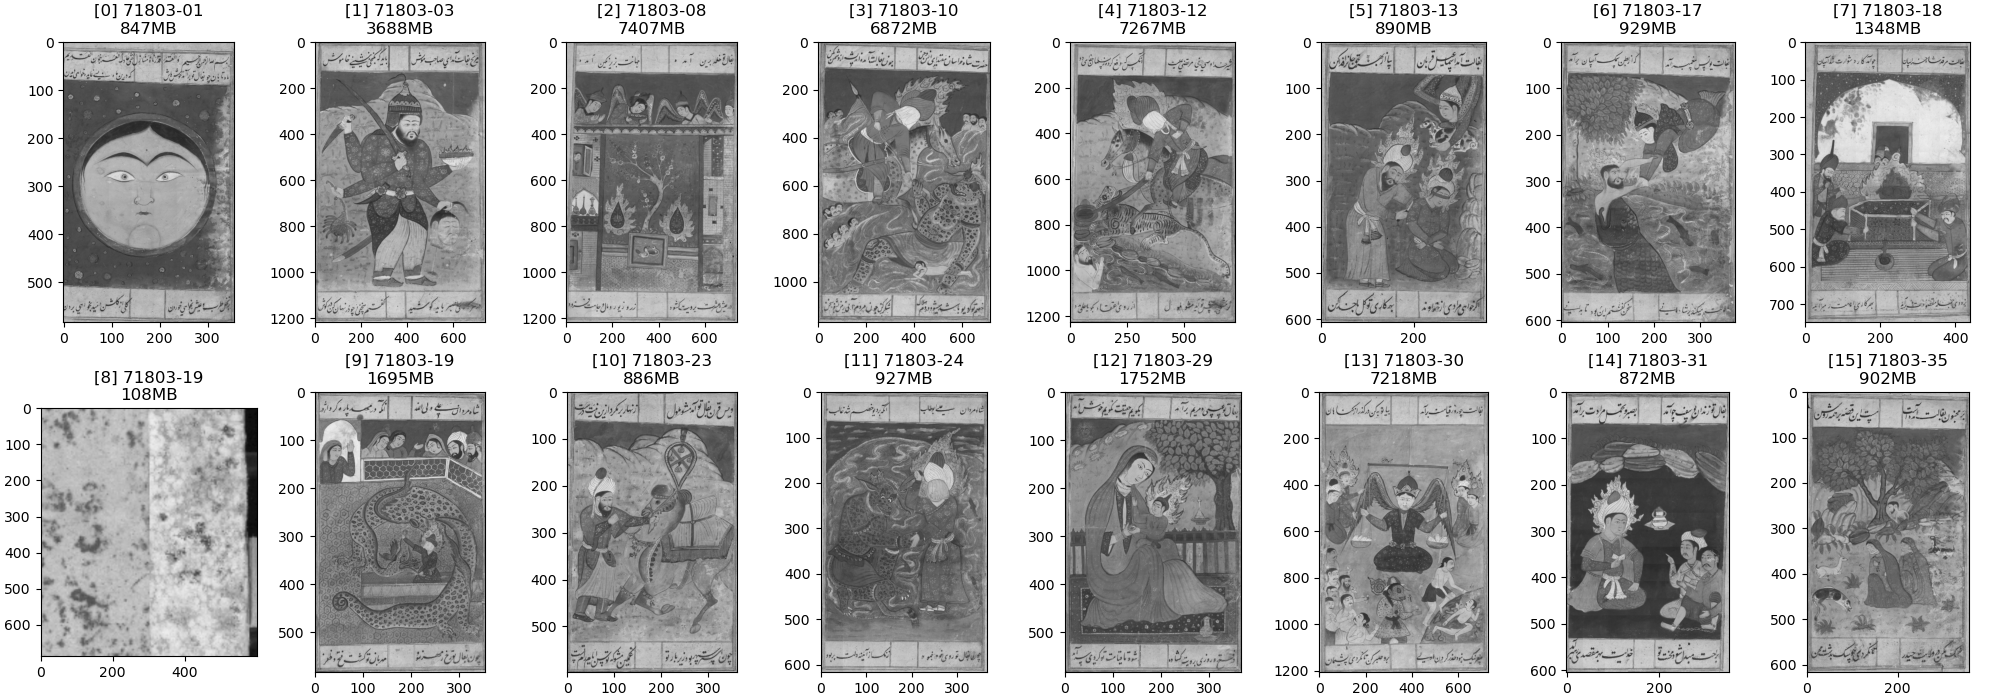

In [6]:
fig, axs = plt.subplots(ncols=8, nrows=2, figsize=[20, 7], layout='constrained')

axs = axs.flatten()

for i, [ax, im, obj_num, size] in enumerate(zip(axs, video_ims, object_nums, raw_sizes)): 
    ax.imshow(im)
    ax.set_title(f'[{i}] {obj_num}\n{int(size)}MB')

## Generating raw previews (done)

In [7]:
for raw_file, rpl_file in zip(raw_files, rpl_files): 
    print(f'{raw_file}\n{rpl_file}')
    mx.make_raw_preview(raw_file, rpl_file, output_dir='data/interim/maxrf/previews');

./data/raw/Weimar-folders/Weimar-XRF/71803-01_MA-XRF/WM-71803-01_400_600_50.raw
./data/raw/Weimar-folders/Weimar-XRF/71803-01_MA-XRF/WM-71803-01_400_600_50.rpl
Saving: data/interim/maxrf/previews/WM-71803-01_400_600_50.raw_preview.png...
./data/raw/Weimar-folders/Weimar-XRF/71803-03_MA-XRF/WM-71803-03_250_300_50.raw
./data/raw/Weimar-folders/Weimar-XRF/71803-03_MA-XRF/WM-71803-03_250_300_50.rpl
Saving: data/interim/maxrf/previews/WM-71803-03_250_300_50.raw_preview.png...
./data/raw/Weimar-folders/Weimar-XRF/71803-08_MA-XRF/WM-71803-08_250_300_50.raw
./data/raw/Weimar-folders/Weimar-XRF/71803-08_MA-XRF/WM-71803-08_250_300_50.rpl
Saving: data/interim/maxrf/previews/WM-71803-08_250_300_50.raw_preview.png...
./data/raw/Weimar-folders/Weimar-XRF/71803-10_MA-XRF/WM-71803-10_250_300_50.raw
./data/raw/Weimar-folders/Weimar-XRF/71803-10_MA-XRF/WM-71803-10_250_300_50.rpl
Saving: data/interim/maxrf/previews/WM-71803-10_250_300_50.raw_preview.png...
./data/raw/Weimar-folders/Weimar-XRF/71803-12_MA

## Generating datastack files 

In [14]:
for i, [raw_file, rpl_file] in enumerate(zip(raw_files, rpl_files)): 
    n = len(raw_files)
    print(f'{i}/{n-1} Creating datastack from: {raw_file}                                                                                                          ...', end='\r')
    mx.raw_to_datastack(raw_file, rpl_file, output_dir='./data/interim/maxrf/datastacks/')

Please wait while preparing data conversion...r-folders/Weimar-XRF/71803-01_MA-XRF/WM-71803-01_400_600_50.raw                                                                                                          ...
Parsing ./data/raw/Weimar-folders/Weimar-XRF/71803-01_MA-XRF/WM-71803-01_400_600_50.rpl: 
key        	 value

width      	 355

height     	 583

depth      	 4096

offset     	 0

data-Length	 1

data-type  	 unsigned

byte-order 	 dont-care

record-by  	 vector

Creating memory map...
Writing: ./data/interim/maxrf/datastacks/WM-71803-01_400_600_50.datastack...
[########################################] | 100% Completed | 10.57 ss


ValueError: Store is read-only but mode is 'r+'

In [15]:
import zarr

In [ ]:
zarr.group()

In [9]:
zarr.__version__

'3.0.4'

In [10]:
import dask

In [11]:
dask.__version__

'2024.11.2'

In [12]:
from zarr.storage import ZipStore

In [13]:
import zarr

In [ ]:
zarr.group()

In [ ]:
# compute sum and max spectra and append to zipstore 

y_max, y_sum = max_and_sum_spectra(datastack_file, datapath=L.MAXRF_CUBE)

append(y_max, L.MAXRF_MAXSPECTRUM, datastack_file)
append(y_sum, L.MAXRF_SUMSPECTRUM, datastack_file)

    